# Malaria Detection Ai



## Autoreload for Matplotlib Inline Graphs

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Imports / Dependencies

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fastai import *
from fastai.vision import *

torch.cuda.is_available()

True

# Get Data

Classes: 
 ['Parasitized', 'Uninfected']


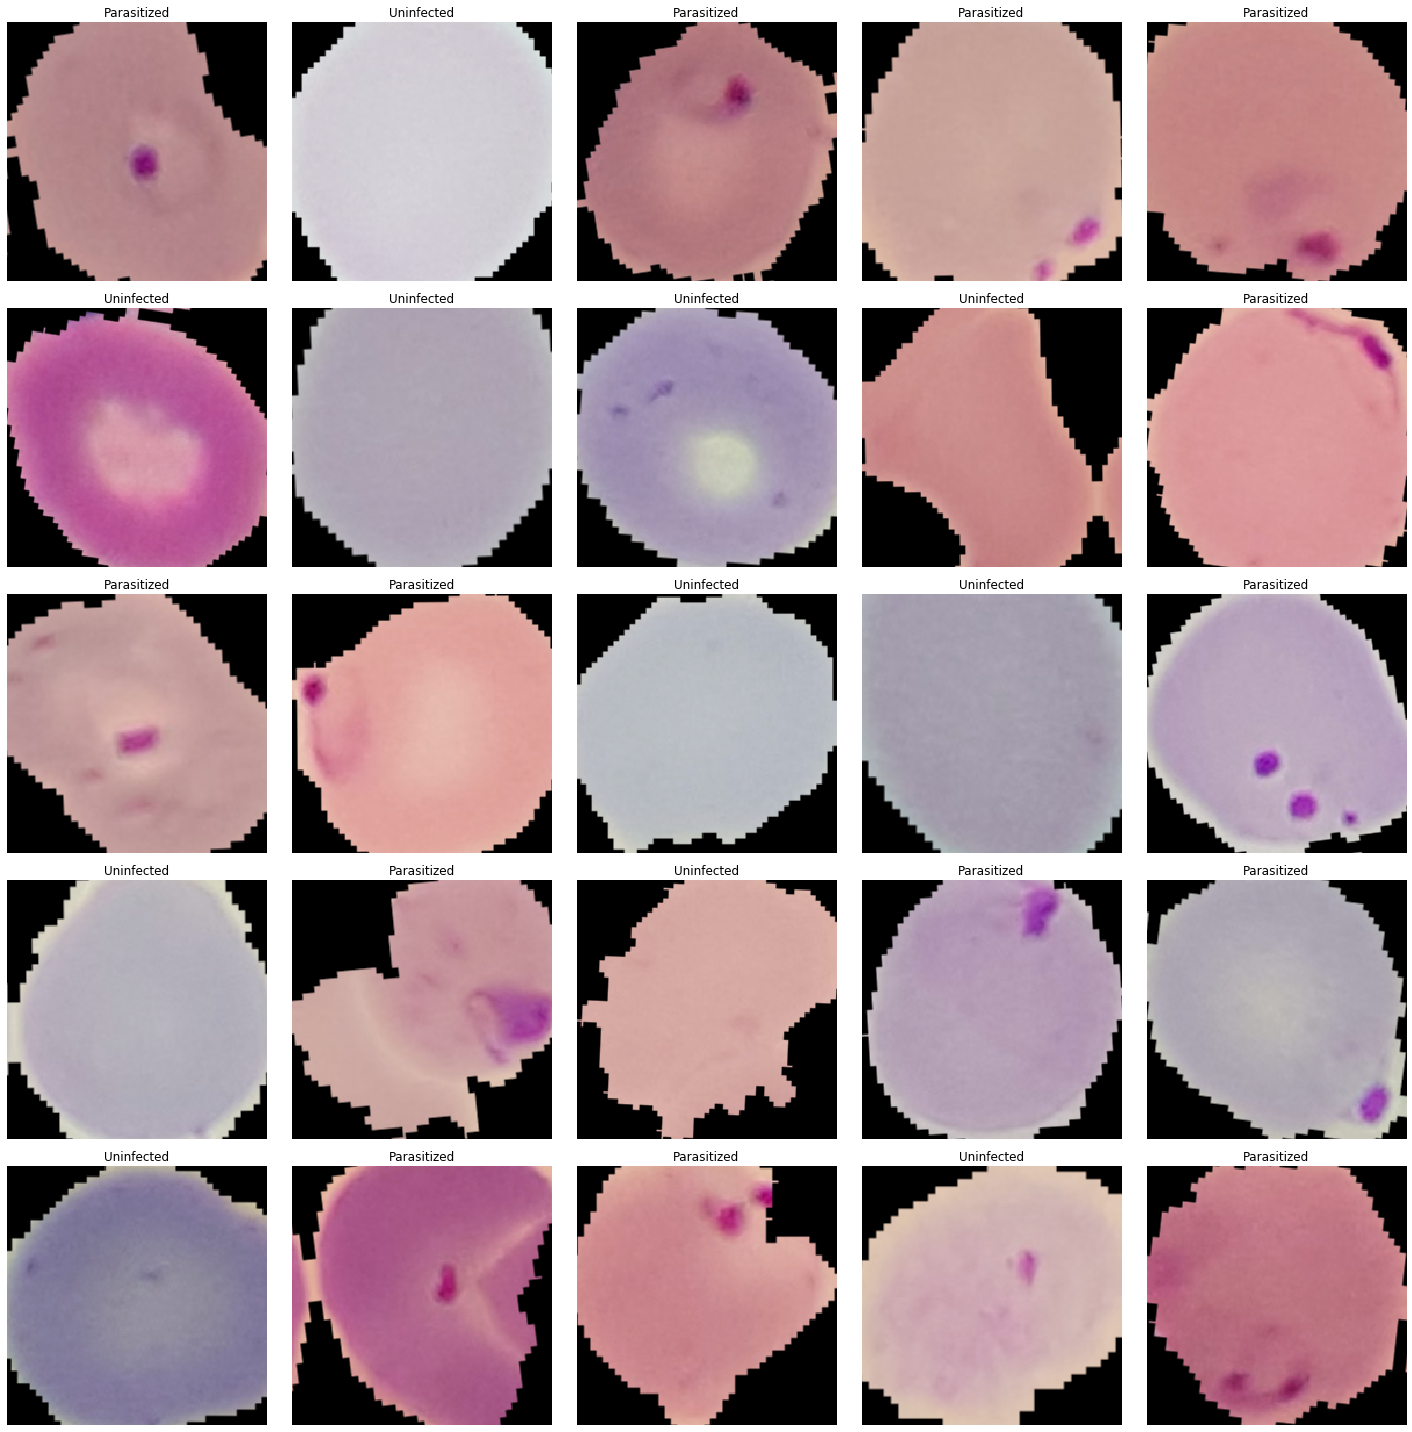

In [3]:
image_path = os.path.abspath('../input/cell-images-for-detecting-malaria/cell_images')
data = ImageDataBunch.from_folder(image_path, 
                                  train=".",
                                  valid_pct=0.2, 
                                  ds_tfms=get_transforms(flip_vert=True, max_warp=0),
                                  size=224,bs=64, 
                                  num_workers=0).normalize(imagenet_stats)
data.show_batch(rows=5)
print(f'Classes: \n {data.classes}')


## Model Development

I will use a Resnet50 model for image classification. 

### Learning Rate Evaluation
Based on the code below the ideal learn rate is 1e-01


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


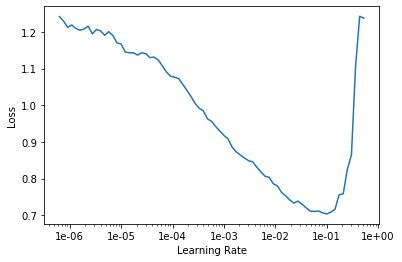

In [4]:
learn = cnn_learner(data, models.resnet50, metrics=[accuracy, error_rate], model_dir="/temp/model/")

learn.lr_find()
learn.recorder.plot()


### Model Fitting

In [5]:
learn_rate = 1e-01
learn.fit_one_cycle(2, slice(learn_rate))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.225276,0.193374,0.938311,0.061689,10:32
1,0.109110,0.086658,0.966887,0.033113,09:14


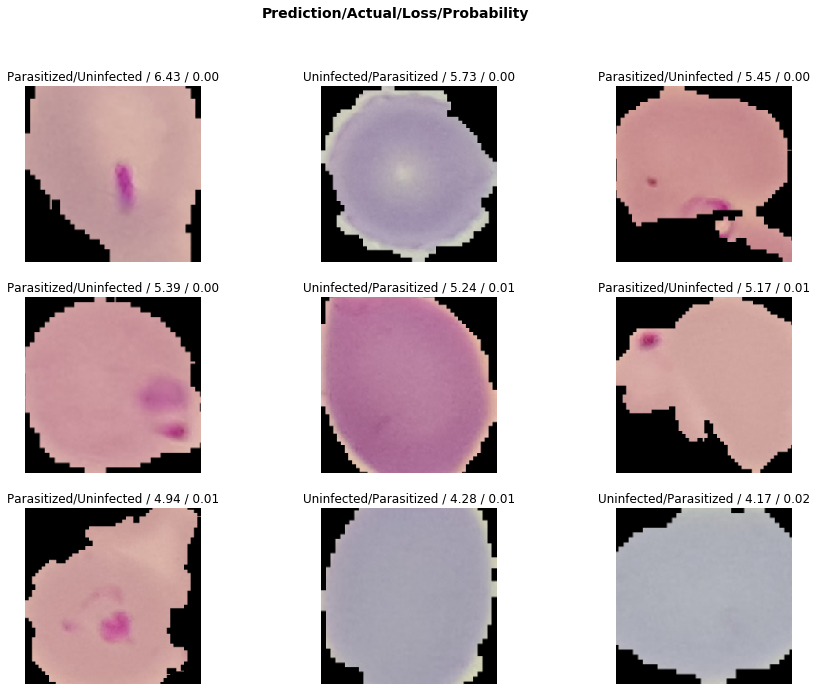

In [6]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

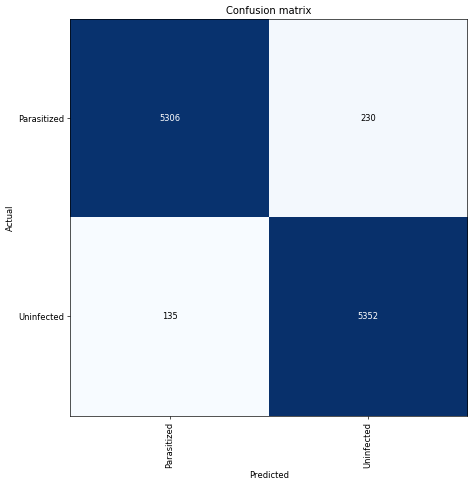

In [7]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=60)

In [8]:
learn.model_dir = "/kaggle/working"
learn.save('stage-1-rn50')

## Stage 2 Model Development 

In [9]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


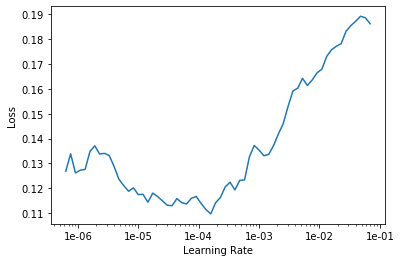

In [10]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(5, slice(1e-5, learn_rate/5))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.144363,0.105484,0.962351,0.037649,10:13
1,0.142853,0.098971,0.964801,0.035199,10:09
2,0.116638,0.082193,0.969518,0.030482,10:07
3,0.103512,0.077579,0.971968,0.028032,10:06
4,0.090122,0.073694,0.973601,0.026399,10:08


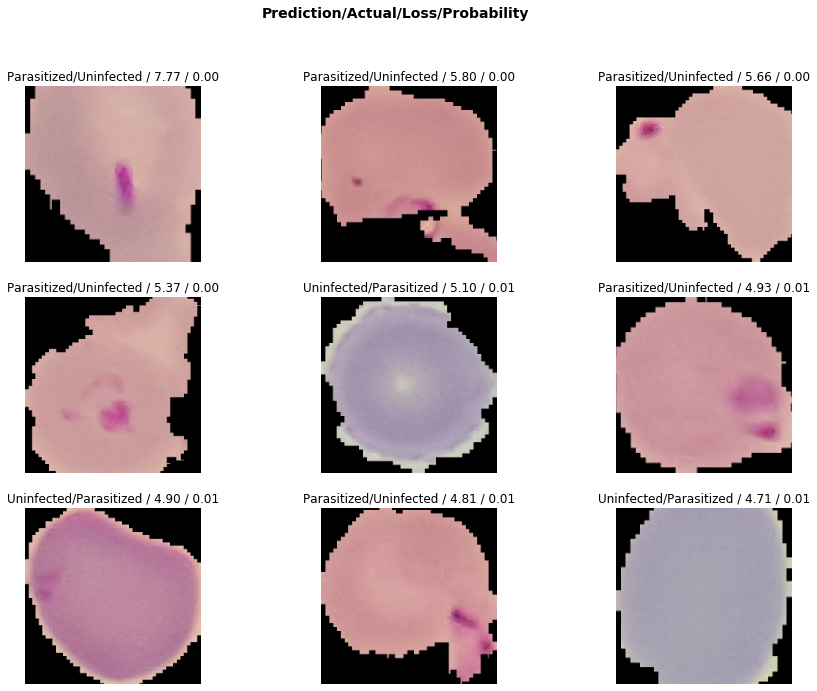

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,11))

In [13]:
learn.save('stage-2-rn50')

## Review / Improve  Model

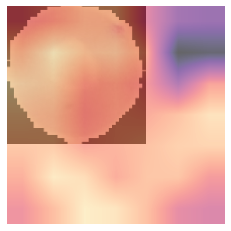

In [14]:
from fastai.callbacks.hooks import *

idx=0
x,y = data.valid_ds[idx]
eval_model = learn.model.eval();
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

def hooked_backward(cat=y):
    with hook_output(eval_model[0]) as hook_a: 
        with hook_output(eval_model[0], grad=True) as hook_g:
            preds = eval_model(xb)
            preds[0,int(cat)].backward()
    return hook_a, hook_g

def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

hook_a, hook_g = hooked_backward()

acts  = hook_a.stored[0].cpu()
acts.shape

grad = hook_g.stored[0][0].cpu()
grad_chan = grad.mean(1).mean(1)
grad.shape,grad_chan.shape

mult = (acts*grad_chan[...,None,None]).mean(0)
show_heatmap(mult)